<a href="https://colab.research.google.com/github/snoop2head/murder_hornet_hunter/blob/master/bee_vs_wasp_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://www.kaggle.com/pallavisinha12/bee-wasp-pytorch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
import copy
import torch.optim as optim


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
!git clone https://github.com/snoop2head/murder_hornet_hunter

Cloning into 'study_in_yellow'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 17833 (delta 0), reused 0 (delta 0), pack-reused 17830
Receiving objects: 100% (17833/17833), 670.79 MiB | 35.03 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (17964/17964), done.


In [ ]:
ROOT = './murder_hornet_hunter/kaggle_bee_vs_wasp'

In [ ]:
data = pd.read_csv(f"{ROOT}/labels.csv")
data.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data["label"])
data["label"] = le.transform(data["label"])


In [ ]:
for i in data.index:
    data["path"].iloc[i] = data["path"].iloc[i].replace("\\", "/")

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
def split(dt):
    idx = []
    a = pd.DataFrame()
    b = pd.DataFrame()
    for i in data.index:
        if data["is_validation"].iloc[i] == 1:
            a = a.append(dt.iloc[i])
            idx.append(i)
        if data["is_final_validation"].iloc[i] == 1:
            b = b.append(dt.iloc[i])
            idx.append(i)
    dt = dt.drop(dt.index[idx])
    a = a.reset_index()
    b = b.reset_index()
    dt = dt.reset_index()
    return dt,a,b
      

In [ ]:
train_df, val_df, test_df = split(data)
print("Length of train dataset: ", len(train_df))
print("Length of validation dataset: " ,len(val_df))
print("Length of test dataset: ", len(test_df))

Length of train dataset:  7939
Length of validation dataset:  1719
Length of test dataset:  1763


In [ ]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
val_df.label = val_df.label.astype(np.int64)
test_df.label = test_df.label.astype(np.int64)

In [ ]:
class Bee_Wasp(Dataset):
    def __init__(self, df:pd.DataFrame, imgdir:str,
                 transforms=None):
        self.df = df
        self.imgdir = imgdir
        self.transforms = transforms
    
    def __getitem__(self, index):
        im_path = os.path.join(self.imgdir, self.df.iloc[index]["path"])
        x = cv2.imread(im_path)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x, (224, 224))

        if self.transforms:
            x = self.transforms(x)
            
        y = self.df.iloc[index]["label"]
        return x, y
    
    def __len__(self):
        return len(self.df)

In [ ]:
train_data = Bee_Wasp(df=train_df,
                        imgdir=f"{ROOT}",
                        transforms=train_transform)

val_data = Bee_Wasp(df=val_df,
                      imgdir=f"{ROOT}",
                      transforms=test_transform)

test_data = Bee_Wasp(df=test_df,
                       imgdir=f"{ROOT}",
                       transforms=test_transform)


In [ ]:
train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=32, num_workers=4)
val_loader = DataLoader(dataset = val_data, shuffle = True, batch_size = 32, num_workers=4)
test_loader = DataLoader(dataset=test_data, shuffle=True, batch_size=32, num_workers=4)

In [ ]:
import os
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)


torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
model = torchvision.models.resnet50(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
for p in model.parameters():
    p.requires_grad = False

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024,4),
    nn.LogSoftmax(dim=1)
)

In [ ]:
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([1024, 2048])
torch.Size([1024])
torch.Size([4, 1024])
torch.Size([4])


In [ ]:
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss()


In [ ]:
def evaluation(dataloader):
    total, correct = 0,0
    model.eval()
    for data in dataloader:
        inputs, labels = data
        inputs =inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _ , pred = torch.max(outputs.data, 1 )
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100*correct/total


In [ ]:
batch_size = 32
import copy
loss_epoch_arr = []
max_epochs = 6
min_loss = 1000
n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_loader):
        inputs,labels = data
        inputs = inputs.to(device)
        labels =  labels.to(device)
        opt.zero_grad()
        model.train()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        if min_loss>loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.2f' % min_loss)
            del inputs, labels, outputs
            torch.cuda.empty_cache()
    loss_epoch_arr.append(loss.item())
    model.eval()
    print("Epoch %d/%d, Train acc: %0.2f, Val acc: %0.2f" %(epoch, max_epochs, evaluation(train_loader), evaluation(val_loader)))


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd3b4ad7d68>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Min loss 1.41
Min loss 1.41
Min loss 1.29
Min loss 0.97
Min loss 0.84
Min loss 0.75
Min loss 0.71
Min loss 0.65
Min loss 0.62


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd3b4ad7d68>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Min loss 0.46
Min loss 0.46
Min loss 0.29
Min loss 0.28
Min loss 0.21


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd3b4ad7d68>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Min loss 0.14


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fd3b4ad7d68>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Min loss 0.13
Min loss 0.08
Min loss 0.08
Epoch 0/6, Train acc: 90.31, Val acc: 91.56
Min loss 0.05
Min loss 0.02
Epoch 1/6, Train acc: 91.52, Val acc: 92.26
Epoch 2/6, Train acc: 91.18, Val acc: 91.04
Epoch 3/6, Train acc: 91.46, Val acc: 91.27
Epoch 4/6, Train acc: 92.67, Val acc: 92.26
Epoch 5/6, Train acc: 92.29, Val acc: 91.22


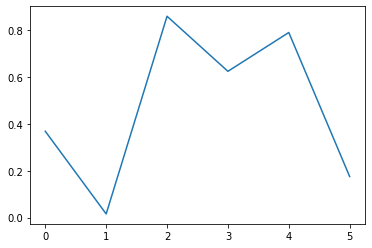

In [ ]:
plt.plot(loss_epoch_arr)
plt.show()


In [ ]:
model.load_state_dict(best_model)
print(evaluation(test_loader))


91.26488939307998


In [ ]:
classes = ['bee', 'wasp', 'other_insect', 'noninsect']
dataiter = iter(test_loader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


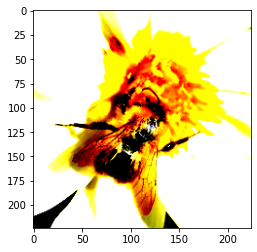

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(images[:1]))

In [ ]:
print("Ground_Truth - ")
print(classes[labels[0]])
images = images.to(device)
outputs = model(images)
max_values, pred_class = torch.max(outputs.data, 1)
print("Predicted_class - ")
print(classes[pred_class[0]])


Ground_Truth - 
bee
Predicted_class - 
bee
